# Download dataset

In [1]:
!git clone https://github.com/TAUTOLOGY-EDUCATION/DATASET

fatal: destination path 'DATASET' already exists and is not an empty directory.


# Import modules

In [2]:
import numpy as np
import pickle
import cv2
from os import listdir

from sklearn.preprocessing import LabelBinarizer
# from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

print(tensorflow.__version__)
print(tensorflow.config.list_physical_devices('GPU'))

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

2022-08-10 04:14:56.829224: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-10 04:14:57.742988: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-10 04:14:57.743588: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-10 04:14:57.808431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 04:14:57.808818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 with Max-Q Design computeCapability: 7.5
coreClock: 1.185GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2022-08-10 04:14:57.808853: I tensorflow/stream_ex

# Prepare data

In [ ]:
# Define constants
EPOCHS = 100
INIT_LR = 1e-3
BS = 32

width=256
height=256

default_image_size = tuple((width, height))
depth=3

directory_root = './DATASET/HorapaVsKaprao/'

In [5]:
# Convert Image to Array with resizing to square
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            height, width, channels = image.shape

            if height > width:
              image = image[height//2 - width//2:height//2 + width//2, 0:width]
            else:
              image = image[0:height, width//2 - height//2:width//2 + height//2]

            image = cv2.resize(image, default_image_size)
            
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
# Load images
image_list, label_list = [], []

# or you can use image_dataset_from_directory

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_name in root_dir :
        print(f"[INFO] Processing {plant_name} ...")

        plant_image_list = listdir(f"{directory_root}/{plant_name}")

        for image in plant_image_list:
            image_path = f"{directory_root}/{plant_name}/{image}"
            if image_path.endswith(".jpg") or image_path.endswith(".JPG"):
                image_list.append(convert_image_to_array(image_path))
                label_list.append(plant_name)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing horapa ...
[INFO] Processing kaprao ...
[INFO] Image loading completed


In [7]:
# Labeling
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(f"There are {n_classes} classes which is {', '.join(label_binarizer.classes_)}")

There are 2 classes which is horapa, kaprao


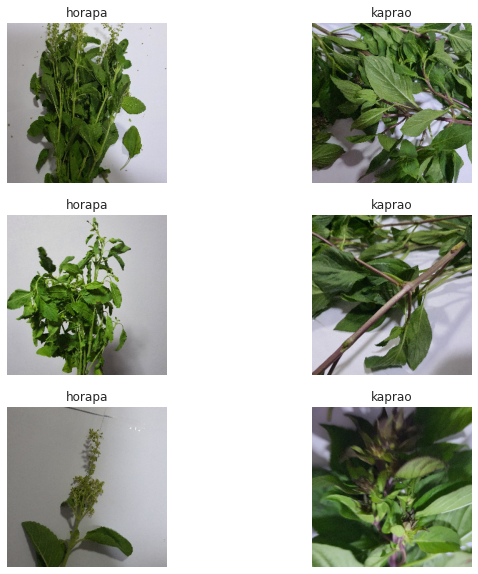

In [9]:
# Preprocessing image
np_image_list = np.array(image_list, dtype=np.float16)

# Show sample of dataset
plt.figure(figsize=(10, 10))

for i in range(6):
  if i % 2 == 0:
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(cv2.cvtColor(image_list[460+i] / 255., cv2.COLOR_BGR2RGB))
    plt.title(label_binarizer.classes_[i%2])
    plt.axis("off")
  else:
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(cv2.cvtColor(image_list[i] / 255., cv2.COLOR_BGR2RGB))
    plt.title(label_binarizer.classes_[i%2])
    plt.axis("off")

In [10]:
# Splitting the data into train, validate, and test set
print("[INFO] Spliting data to train, validate, and test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 2)

print(f"[INFO] All dataset: {len(image_list)}")
print(f"[INFO] Training dataset: {len(y_train)}")
print(f"[INFO] Validation dataset: {len(y_val)}")
print(f"[INFO] Testing dataset: {len(y_test)}")

[INFO] Spliting data to train, validate, and test
[INFO] All dataset: 535
[INFO] Training dataset: 342
[INFO] Validation dataset: 86
[INFO] Testing dataset: 107


In [11]:
# Class weighting
print("[INFO] Class weighting...")
class_weights = class_weight.compute_class_weight(
                                                  'balanced',
                                                  classes=np.unique(np.ravel(y_train, order='C')),
                                                  y=np.ravel(y_train, order='C'))

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

[INFO] Class weighting...
{0: 0.5916955017301038, 1: 3.2264150943396226}


In [12]:
# Data augmentation
aug = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True, 
        fill_mode="nearest")

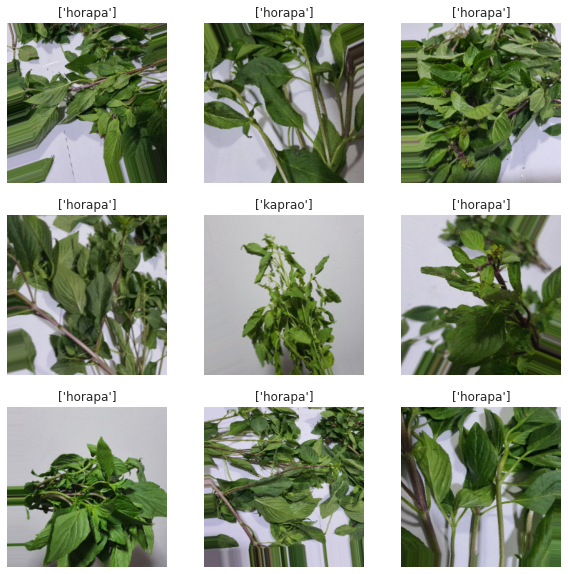

In [13]:
plt.figure(figsize=(10, 10))

image_flow = aug.flow(x_train, y_train, batch_size=BS)

for i in range(9):
  img, label = image_flow.next()
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(cv2.cvtColor(img[0] / 255., cv2.COLOR_BGR2RGB))
  plt.title(label_binarizer.classes_[label[0]])
  plt.axis("off")

# Create model

In [14]:
print("[INFO] Creating model...")
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
# model.add(Dense(n_classes, activation='softmax')) # <-- for multi-classes

model.summary()

# Learning rate tuning
lr_schedule = LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

[INFO] Making model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (Non

2022-08-10 04:16:25.707040: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-10 04:16:25.707263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 04:16:25.707666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 with Max-Q Design computeCapability: 7.5
coreClock: 1.185GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2022-08-10 04:16:25.707715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-10 04:16:25.707735: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-10 04:16:25.707749: I tensorflow/stream

## Training with `LearningRateScheduler` to find an appropriate learning rate

In [25]:
print("[INFO] training...")

history = model.fit(
            aug.flow(x_train, y_train, batch_size=BS),
            validation_data=(x_val, y_val),
            steps_per_epoch=len(x_train) // BS,
            epochs=EPOCHS,
            verbose=1,
            callbacks=[lr_schedule],
            class_weight=class_weight_dict)

[INFO] training...
Epoch 1/100
10/10 [==============================] - 3s 315ms/step - loss: 0.7018 - accuracy: 0.9065 - val_loss: 0.3836 - val_accuracy: 0.9535
Epoch 2/100
10/10 [==============================] - 3s 330ms/step - loss: 0.5950 - accuracy: 0.9161 - val_loss: 0.3839 - val_accuracy: 0.9535
Epoch 3/100
10/10 [==============================] - 3s 316ms/step - loss: 0.6850 - accuracy: 0.9125 - val_loss: 0.3843 - val_accuracy: 0.9535
Epoch 4/100
10/10 [==============================] - 3s 312ms/step - loss: 0.6504 - accuracy: 0.9065 - val_loss: 0.3847 - val_accuracy: 0.9535
Epoch 5/100
10/10 [==============================] - 3s 303ms/step - loss: 0.5876 - accuracy: 0.9129 - val_loss: 0.3853 - val_accuracy: 0.9535
Epoch 6/100
10/10 [==============================] - 3s 304ms/step - loss: 0.6975 - accuracy: 0.8935 - val_loss: 0.3858 - val_accuracy: 0.9535
Epoch 7/100
10/10 [==============================] - 3s 305ms/step - loss: 0.5290 - accuracy: 0.9226 - val_loss: 0.3865 - v

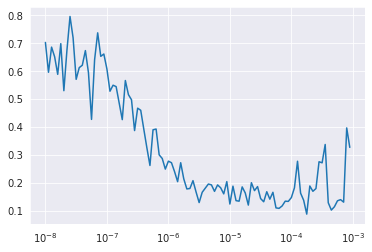

In [26]:
# plot the training results to see the loss against LR
lrs = 1e-8 * 10**(np.arange(EPOCHS)/20)
plt.semilogx(lrs, history.history["loss"])
#plt.axis([1e-8, 1e-3, 0, 300])

# Training the model again, this time for real
### Now we set the LR to the new value

In [27]:
NEW_LR = 1e-5
optimizer = Adam(learning_rate=NEW_LR, decay=NEW_LR / EPOCHS)

In [28]:
# Early Stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

es = EarlyStopping(monitor='val_accuracy',
                    verbose=1,
                    patience=20,
                    mode='max',
                    restore_best_weights=True)

In [29]:
print("[INFO] training...")

history = model.fit(
            aug.flow(x_train, y_train, batch_size=BS),
            validation_data=(x_val, y_val),
            steps_per_epoch=len(x_train) // BS,
            epochs=EPOCHS,
            verbose=1,
            callbacks=[es],
            class_weight=class_weight_dict)

[INFO] training...
Epoch 1/100
10/10 [==============================] - 3s 316ms/step - loss: 0.2028 - accuracy: 0.9156 - val_loss: 1.5198 - val_accuracy: 0.4419
Epoch 2/100
10/10 [==============================] - 3s 307ms/step - loss: 0.2260 - accuracy: 0.9031 - val_loss: 0.5628 - val_accuracy: 0.7093
Epoch 3/100
10/10 [==============================] - 3s 291ms/step - loss: 0.1570 - accuracy: 0.9290 - val_loss: 0.5889 - val_accuracy: 0.7907
Epoch 4/100
10/10 [==============================] - 3s 305ms/step - loss: 0.1743 - accuracy: 0.9323 - val_loss: 0.4324 - val_accuracy: 0.8721
Epoch 5/100
10/10 [==============================] - 3s 312ms/step - loss: 0.2764 - accuracy: 0.9032 - val_loss: 0.9491 - val_accuracy: 0.5698
Epoch 6/100
10/10 [==============================] - 3s 309ms/step - loss: 0.1906 - accuracy: 0.9226 - val_loss: 0.7084 - val_accuracy: 0.6628
Epoch 7/100
10/10 [==============================] - 3s 301ms/step - loss: 0.1554 - accuracy: 0.9290 - val_loss: 0.7391 - v

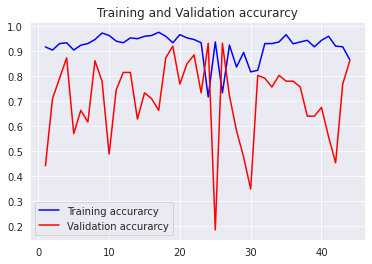

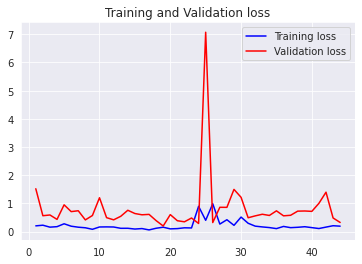

In [30]:
# Show training graph accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [31]:
# Test the model
print("[INFO] Calculating model accuracy")
train_scores = model.evaluate(x_train, y_train)
test_scores = model.evaluate(x_test, y_test)
all_scores = model.evaluate(np_image_list, image_labels)
print(f"Test Accuracy (on train dataset): {train_scores[1]*100}")
print(f"Test Accuracy (on test dataset): {test_scores[1]*100}")
print(f"Test Accuracy (on all dataset): {all_scores[1]*100}")

[INFO] Calculating model accuracy
17/17 [==============================] - 0s 20ms/step - loss: 0.3017 - accuracy: 0.9458
Test Accuracy (on train dataset): 95.32163739204407
Test Accuracy (on test dataset): 93.45794320106506
Test Accuracy (on all dataset): 94.5794403553009


Actual is "horapa" and Prediction is "horapa":  85
Actual is "horapa" and Prediction is "kaprao":  6
Actual is "kaprao" and Prediction is "horapa":  1
Actual is "kaprao" and Prediction is "kaprao":  15
Total Correct Prediction: 100 / 107


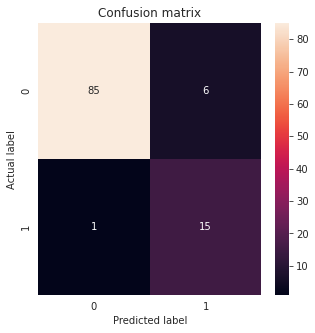

In [32]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'Actual is "{label_binarizer.classes_[0]}" and Prediction is "{label_binarizer.classes_[0]}": ', cm[0][0])
    print(f'Actual is "{label_binarizer.classes_[0]}" and Prediction is "{label_binarizer.classes_[1]}": ', cm[0][1])
    print(f'Actual is "{label_binarizer.classes_[1]}" and Prediction is "{label_binarizer.classes_[0]}": ', cm[1][0])
    print(f'Actual is "{label_binarizer.classes_[1]}" and Prediction is "{label_binarizer.classes_[1]}": ', cm[1][1])
    print(f'Total Correct Prediction: {np.sum(cm[0][0] + cm[1][1])} / {np.sum(cm)}')
    

test_predictions_baseline = model.predict(x_test, batch_size=BS)

plot_cm(y_test, test_predictions_baseline)

**Save model**

In [33]:
# save the model to disk
print("[INFO] Saving model...")
model.save('saved_model/model-v0.h5')

[INFO] Saving model...
